# **HW1**
Amy Liu


## Question 1.

### What is the cell type composition of PBMCs of Sample 1?


We are using Scanpy's read 10x function to read in the h5 sample 1 file into an anndata object, ad10f.

In [32]:
import scanpy as sc
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
plt.rcParams['figure.dpi'] = 300
sc.logging.print_header()

ad10f = sc.read_10x_h5("hw1_data/pbmc_10k_v3_filtered_feature_bc_matrix.h5")
print(ad10f)
ad10f.shape
type(ad10f)


scanpy==1.10.4 anndata==0.11.3 umap==0.5.7 numpy==1.26.4 scipy==1.13.1 pandas==2.2.2 scikit-learn==1.5.1 statsmodels==0.14.2 igraph==0.11.5 pynndescent==0.5.13
AnnData object with n_obs × n_vars = 11769 × 33538
    var: 'gene_ids', 'feature_types', 'genome'


anndata._core.anndata.AnnData

We then need to account for errors in data processing (get rid of the duplicates by making every gene name unique) that may indicate a cell is expressing the same gene more than once (biologically incorrect) and Scanpy is built to only reindex uniquely valued index objects.


In [34]:
gname_counts = ad10f.var_names.value_counts() #counts how many times each gene (ad10f.var_names = gene names) appears
np.any(gname_counts>1) #creates a boolean array

duplicates = gname_counts[gname_counts > 1]
print(duplicates)

ad10f.var_names_make_unique() #function ensures every gene name is unique by appenxing suffixes to names

PDE11A       2
SCO2         2
LINC01505    2
PRSS50       2
ATXN7        2
EMG1         2
CYB561D2     2
LINC01238    2
CCDC39       2
TXNRD3NB     2
ABCF2        2
HSPA14       2
TBCE         2
SOD2         2
RGS5         2
TMSB15B      2
MATR3        2
PINX1        2
POLR2J3      2
DIABLO       2
LINC02203    2
IGF2         2
H2BFS        2
COG8         2
Name: count, dtype: int64


We need to do quality control on the anndata to ensure that a larger number of genes are not mitochondrial or ribosomal as these could make the data look more extreme and distract from the genes that are actually encoding the PBMCs.

In [39]:
#detect mitochondrial and ribosomal genes and calculate QC metrics based on % reads coming from mt and ribo genes
ad10f.var['mt'] = ad10f.var_names.str.startswith('MT-')
ribo_prefix = ("RPS","RPL")
ad10f.var['ribo'] = ad10f.var_names.str.startswith(ribo_prefix)
sc.pp.calculate_qc_metrics(ad10f, qc_vars=['mt','ribo'], percent_top=None, log1p=False, inplace=True)

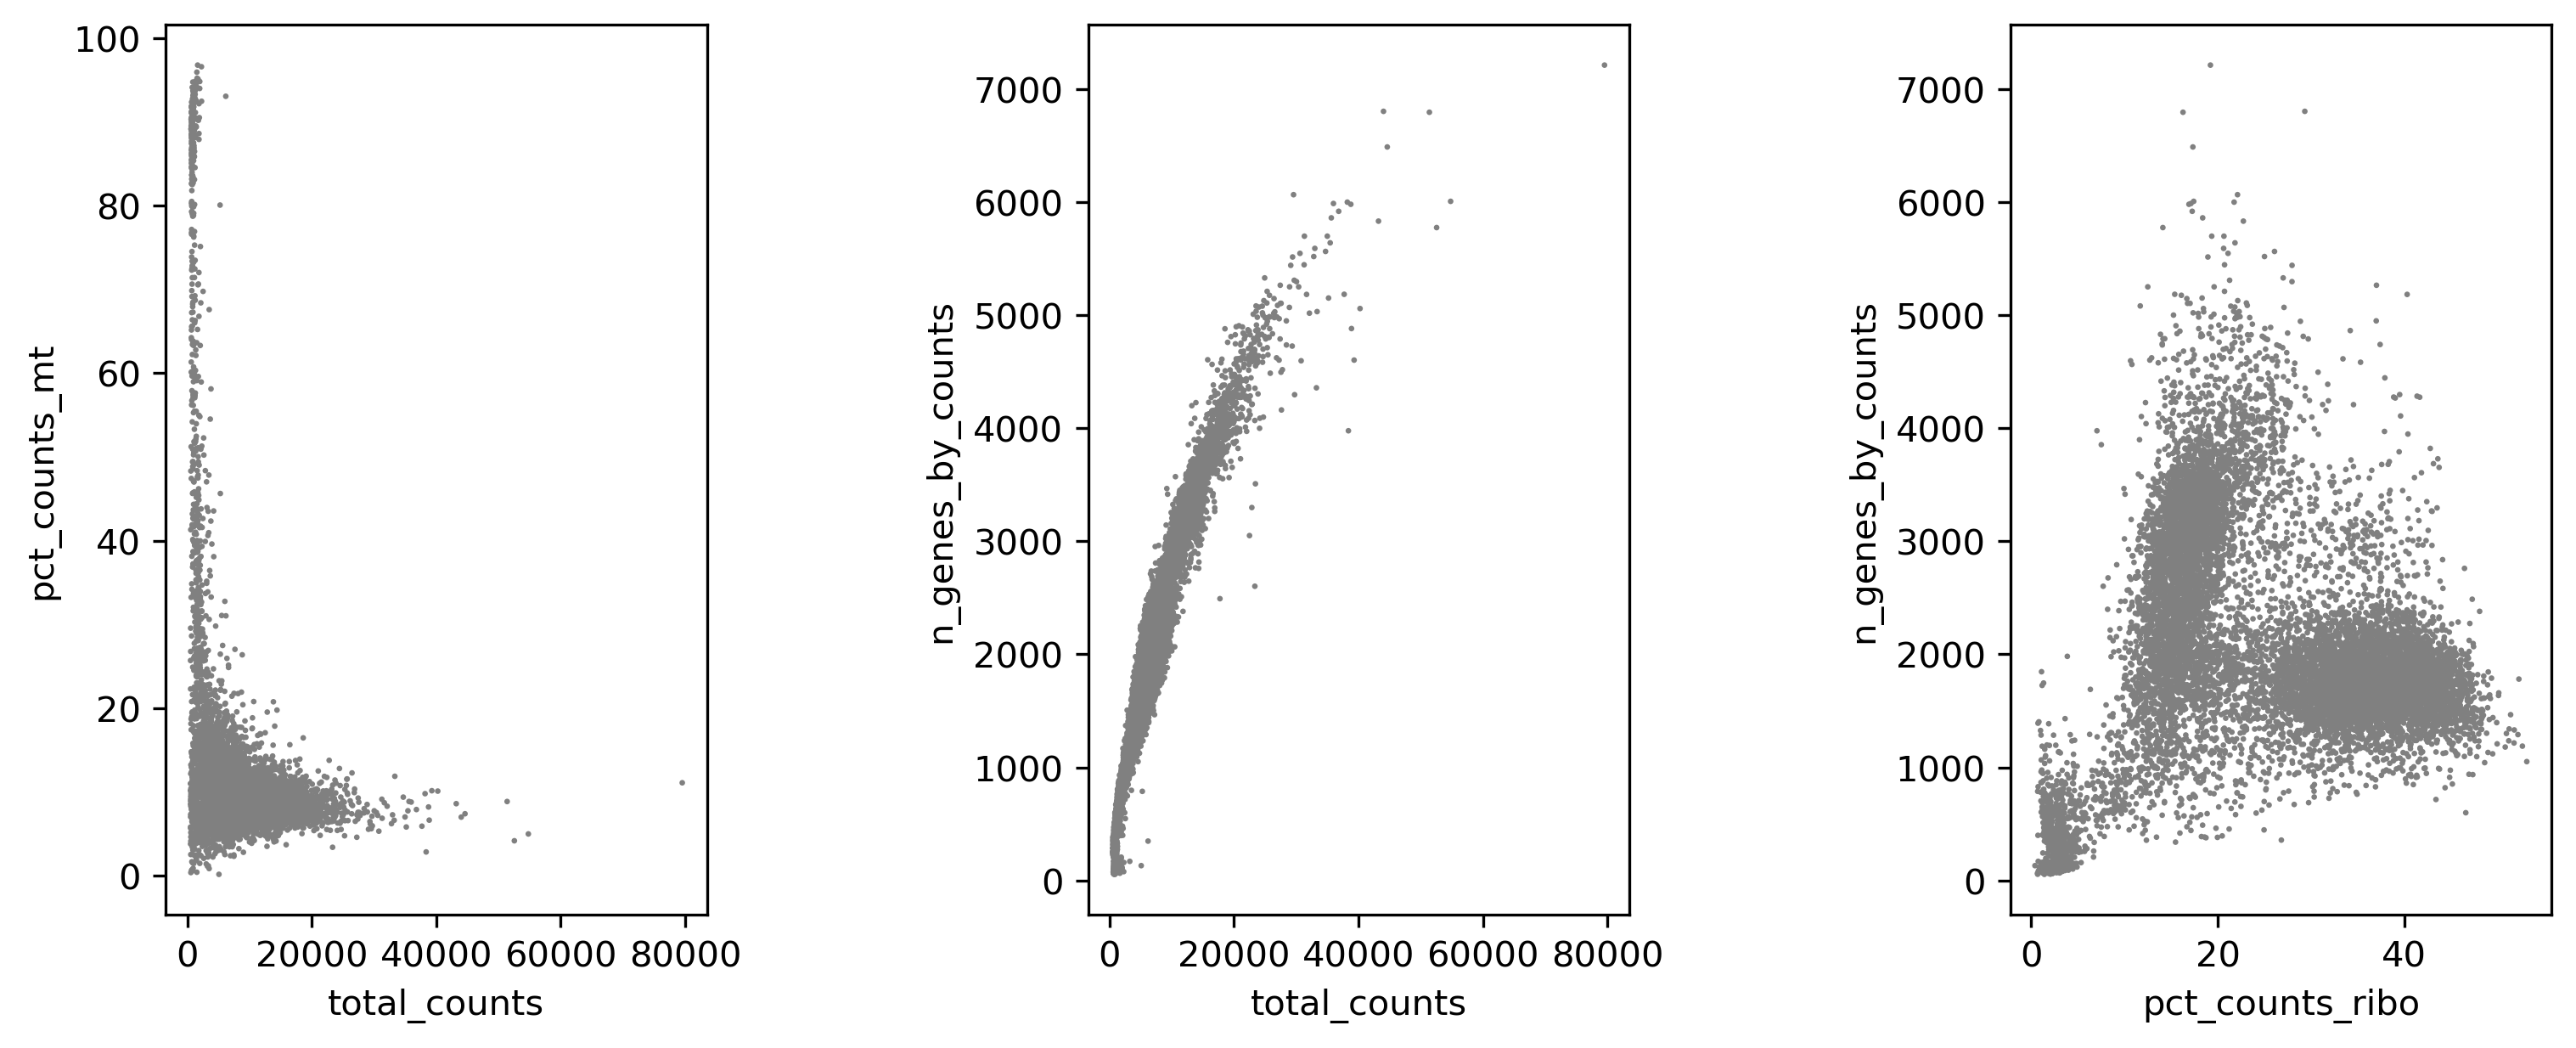

In [41]:
adClean = ad10f.copy() #new copy so filtering doesn't change original data

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(10,4), gridspec_kw={'wspace':0.25}, constrained_layout=True)
#mitochondrial RNA % vs. Total Counts UMI per cell
ax1_dict = sc.pl.scatter(adClean, x='total_counts', y='pct_counts_mt', ax=ax1, show=False)

#Number of Genes Detected Per Cell vs. Total Counts RNA per cell
ax2_dict = sc.pl.scatter(adClean, x='total_counts', y='n_genes_by_counts',ax=ax2, show=False)

#% ribosomal RNA vs. Genes Detected
ax3_dict = sc.pl.scatter(adClean, x='pct_counts_ribo', y='n_genes_by_counts',ax=ax3, show=False)
plt.show()

Based off the scatter plots, since the majority of the data is less than the 20% counts mitochondrial mark, we can just keep the cells that have a pct_counts_mt under 20. However, for pct_counts_ribo, there is data distributed more widely and if we choose a cutoff, we could potentially lose important data. As a result, we will only filter out cells based on mitochondrial genes.

In [44]:
adClean = adClean[adClean.obs['pct_counts_mt']<20,:].copy() #keep cells with fewer mitochondrial encoded gene total UMIs

Another part of QC is filtering out cells that may be damaged and have few detected genes, cells that could be doublets and have a high total counts and genes that are only in a few number of cells, which could be due to random noise rather than biologically relevant information.

In [47]:
sc.pp.filter_cells(adClean, min_genes=500) #total number of genes detected
sc.pp.filter_cells(adClean, max_counts=30000) #total number of counts
sc.pp.filter_genes(adClean, min_cells=3)

We then normalize each cell's total counts to a target sum because some cells may have more detected transcripts than others, leading to skewed data and biases that are not reflective of the relative gene expression. The log transformation also stabilizes variance of the data as genes may be expressed at very different levels.

In [61]:
adNorm = adClean.copy()
adNorm.layers['counts'] = adNorm.X.copy()
sc.pp.normalize_total(adNorm , target_sum=1e4)
sc.pp.log1p(adNorm)

Additionally, we will select genes that are highly variable as these will be the more biologically relevant genes that actually vary across cells and are not just low expression "housekeeping" genes that are constantly expressed across all cells. Using the top principal components, we need to create a K-nearest neighbors graph because this gives the meaningful cell similarity relationships needed for clustering in UMAP and PAGA analyses. We choose neighbors to be 20 because this gives us a balance between clusters that are too fragmented or clusters that connect too many unrelated cells. We chose 10 principal components because it will explain most of the variance in the data and reduce noise.

In [113]:

sc.pp.highly_variable_genes(adNorm , min_mean=0.0125, max_mean=6, min_disp=0.25)
sc.tl.pca(adNorm , use_highly_variable=True)

n_neighbors = 20
n_pcs = 10
sc.pp.neighbors(adNorm, n_neighbors=n_neighbors, n_pcs=n_pcs)
sc.tl.leiden(adNorm,.1)
sc.tl.paga(adNorm) #compute intercluster similarities
sc.pl.paga(adNorm, plot=False) #create internal embedding based on intercluster similarities
sc.tl.umap(adNorm, 0.25, init_pos='paga') #use embedding to start optimization

Some clusters are ambiguous because they express markers of more than one cell type. This could be due to the cluster containing > 1 cell type, or because the cell barcodes are doublets. If former, we can subcluster them. We will do so for clusters 5, 2 and 4, finding that cluster 5 has doublets and can be rid of for further analysis and both clusters 4 and 2 can be subdivided further into two.


In [122]:
sc.tl.leiden(adNorm,.1, restrict_to=["leiden",["5"]])
sc.tl.dendrogram(adNorm, "leiden_R")

sc.tl.leiden(adNorm,.05, restrict_to=["leiden_R",["2"]])
sc.tl.dendrogram(adNorm, "leiden_R")

sc.tl.leiden(adNorm,.1, restrict_to=["leiden_R",["4"]])
sc.tl.dendrogram(adNorm, "leiden_R")

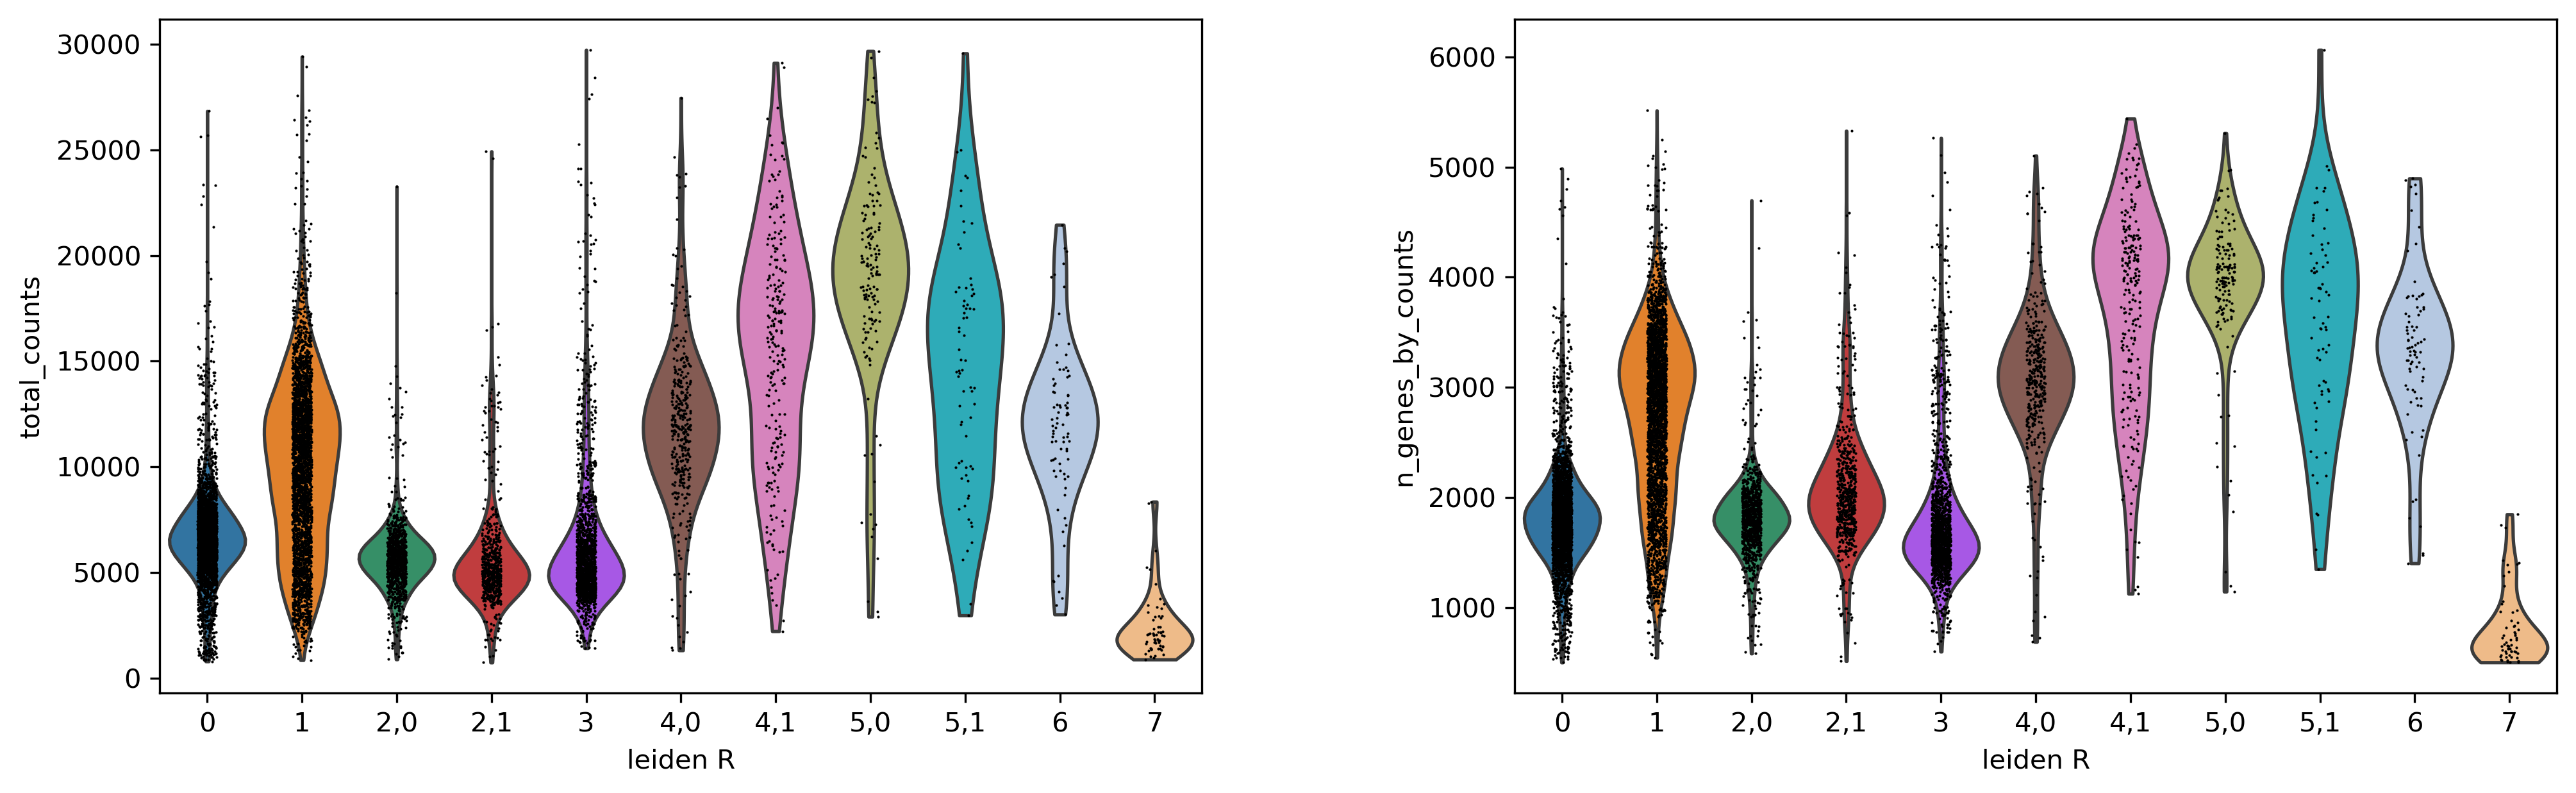

In [116]:
sc.pl.violin(adNorm, ['total_counts', 'n_genes_by_counts'], groupby='leiden_R' )

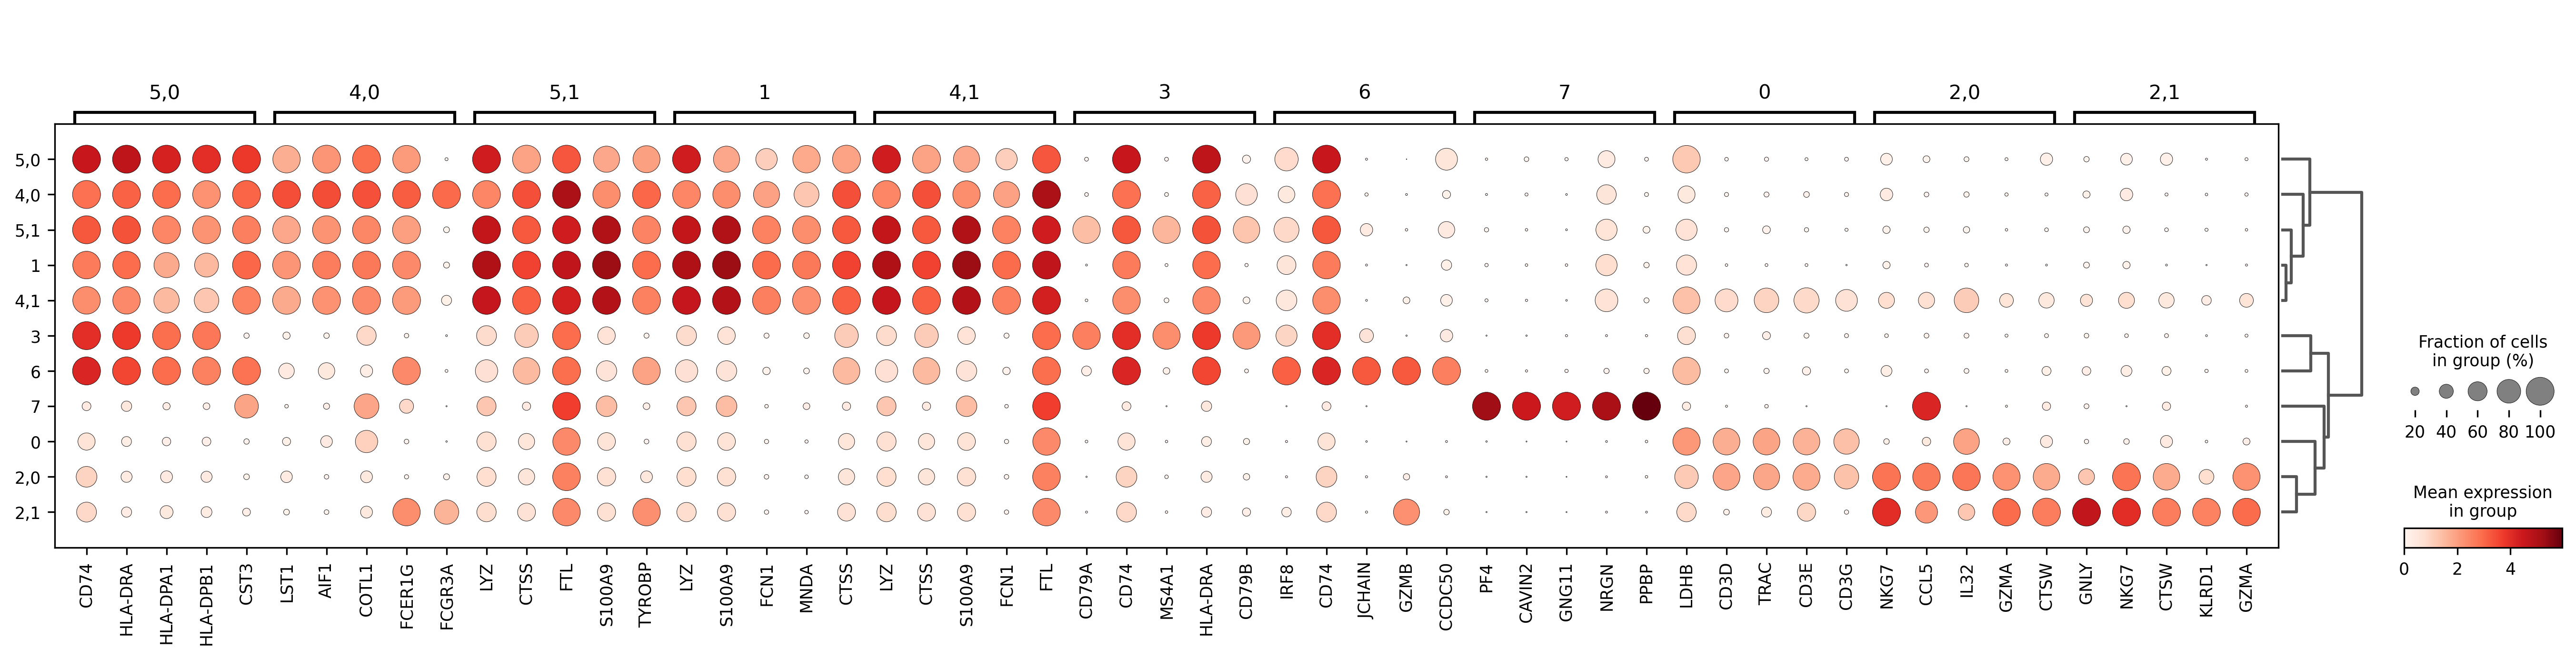

In [128]:

sc.tl.rank_genes_groups(adNorm, use_raw=False, groupby="leiden_R")
sc.pl.rank_genes_groups_dotplot(adNorm, n_genes=5, groupby="leiden_R", dendrogram=True, key='rank_genes_groups')

We decide to discard cluster 5 as it is a doublet and 4,1 as it is a multiplet and are able to assign cell types for each cluster based off known gene expression markers given by the ranked dotplot above and use a new dictionary with genes that are highly indicative of their respective cell type to classify each cell's type and create a new .obs column in the anndata, adNorm2, for it.

In [131]:
tokeep = ["1", "4,0", "3", "6", "7", "0", "2,0", "2,1"]
adNorm2 = adNorm.copy() #create new, clean Anndata
adNorm2 = adNorm2[adNorm2.obs['leiden_R'].isin(tokeep)].copy()

In [133]:
#assign the cell clusters to cell type based on mean expression data
cell_dict = {'Dendritic': ['6'],
             'CD14 Monocyte': ['1'],
             'CD16 Monocyte': ["4,0"],
             'B cell': ['3'],
             'Platelet': ['7'],
             'CD4 T cell': ['0'],
             'CD8 T cell': ["2,0"],
             'NK cell': ["2,1"]
}

#establish new marker genes to use for all the clusters
marker_genes_dict = {
    'B cell': ['CD79A'],
    'Dendritic': ['CLEC4C'],
    'CD14 monocyte': ['CD14'],
    'CD16 monocyte': ['FCGR3A'],
    'NK cell': ['GNLY'],
    'CD4 T cell': ['CD4', 'GATA3'],
    'CD8 T cell': ['CD8A', 'EOMES'],
    'Platelet': ['PF4', 'CAVIN2']
}

#make new obs column for cell type
new_obs_name = 'cell_type'

#initialize all values in the column as undefined
adNorm2.obs[new_obs_name] = np.nan 

for i in cell_dict.keys():
    ind = pd.Series(adNorm2.obs.leiden_R).isin(cell_dict[i])
    adNorm2.obs.loc[ind,new_obs_name] = i

#converting cell type column to a categorical variable
adNorm2.obs['cell_type'] = adNorm2.obs['cell_type'].astype("category") 


**Deliverable 1: Showing the new .obs column (last column) indicating cell type for each cell based on the AnnData adNorm2.**

In [141]:
adNorm2.obs

n_genes_by_counts  total_counts  total_counts_mt  \
AAACCCAAGCGCCCAT-1               1087        2204.0             52.0   
AAACCCACAGAGTTGG-1               1836        5884.0            633.0   
AAACCCACAGGTATGG-1               2216        5530.0            434.0   
AAACCCACATAGTCAC-1               1615        5106.0            553.0   
AAACCCACATCCAATG-1               1800        4572.0            411.0   
...                               ...           ...              ...   
TTTGTTGGTGCGTCGT-1               1336        5115.0            365.0   
TTTGTTGGTGTCATGT-1               1331        3937.0            783.0   
TTTGTTGGTTTGAACC-1               1401        4245.0            375.0   
TTTGTTGTCCAAGCCG-1               1668        5602.0            524.0   
TTTGTTGTCTTACTGT-1               1745        6757.0            520.0   

                    pct_counts_mt  total_counts_ribo  pct_counts_ribo  \
AAACCCAAGCGCCCAT-1       2.359347              392.0        17.785845   
AAACCCACAGAGTTGG-1      10.757988             1043.0        17.726036   
AAACCCACAGGTATGG-1       7.848101              742.0        13.417721   
AAACCCACATAGTCAC-1      10.830396             1734.0        33.960049   
AAACCCACATCCAATG-1       8.989501              871.0        19.050745   
...                           ...                ...              ...   
TTTGTTGGTGCGTCGT-1       7.135875             2471.0        48.308895   
TTTGTTGGTGTCATGT-1      19.888241              606.0        15.392430   
TTTGTTGGTTTGAACC-1       8.833922             1402.0        33.027092   
TTTGTTGTCCAAGCCG-1       9.353803             1985.0        35.433773   
TTTGTTGTCTTACTGT-1       7.695724             2932.0        43.392036   

                    n_genes  n_counts leiden leiden_R      cell_type  
AAACCCAAGCGCCCAT-1     1087    2204.0      0        0     CD4 T cell  
AAACCCACAGAGTTGG-1     1836    5884.0      1        1  CD14 Monocyte  
AAACCCACAGGTATGG-1     2216    5530.0      2      2,1        NK cell  
AAACCCACATAGTCAC-1     1615    5106.0      3        3         B cell  
AAACCCACATCCAATG-1     1800    4572.0      2      2,1        NK cell  
...                     ...       ...    ...      ...            ...  
TTTGTTGGTGCGTCGT-1     1336    5115.0      0        0     CD4 T cell  
TTTGTTGGTGTCATGT-1     1331    3937.0      1        1  CD14 Monocyte  
TTTGTTGGTTTGAACC-1     1401    4245.0      2      2,0     CD8 T cell  
TTTGTTGTCCAAGCCG-1     1668    5602.0      0        0     CD4 T cell  
TTTGTTGTCTTACTGT-1     1745    6757.0      0        0     CD4 T cell  

[10433 rows x 11 columns]

**Deliverable 2: Visualization of cluster-labeled UMAP and marker gene expressions in dotplot.**

categories: B cell, CD14 Monocyte, CD16 Monocyte, etc.
var_group_labels: B cell, Dendritic, CD14 monocyte, etc.


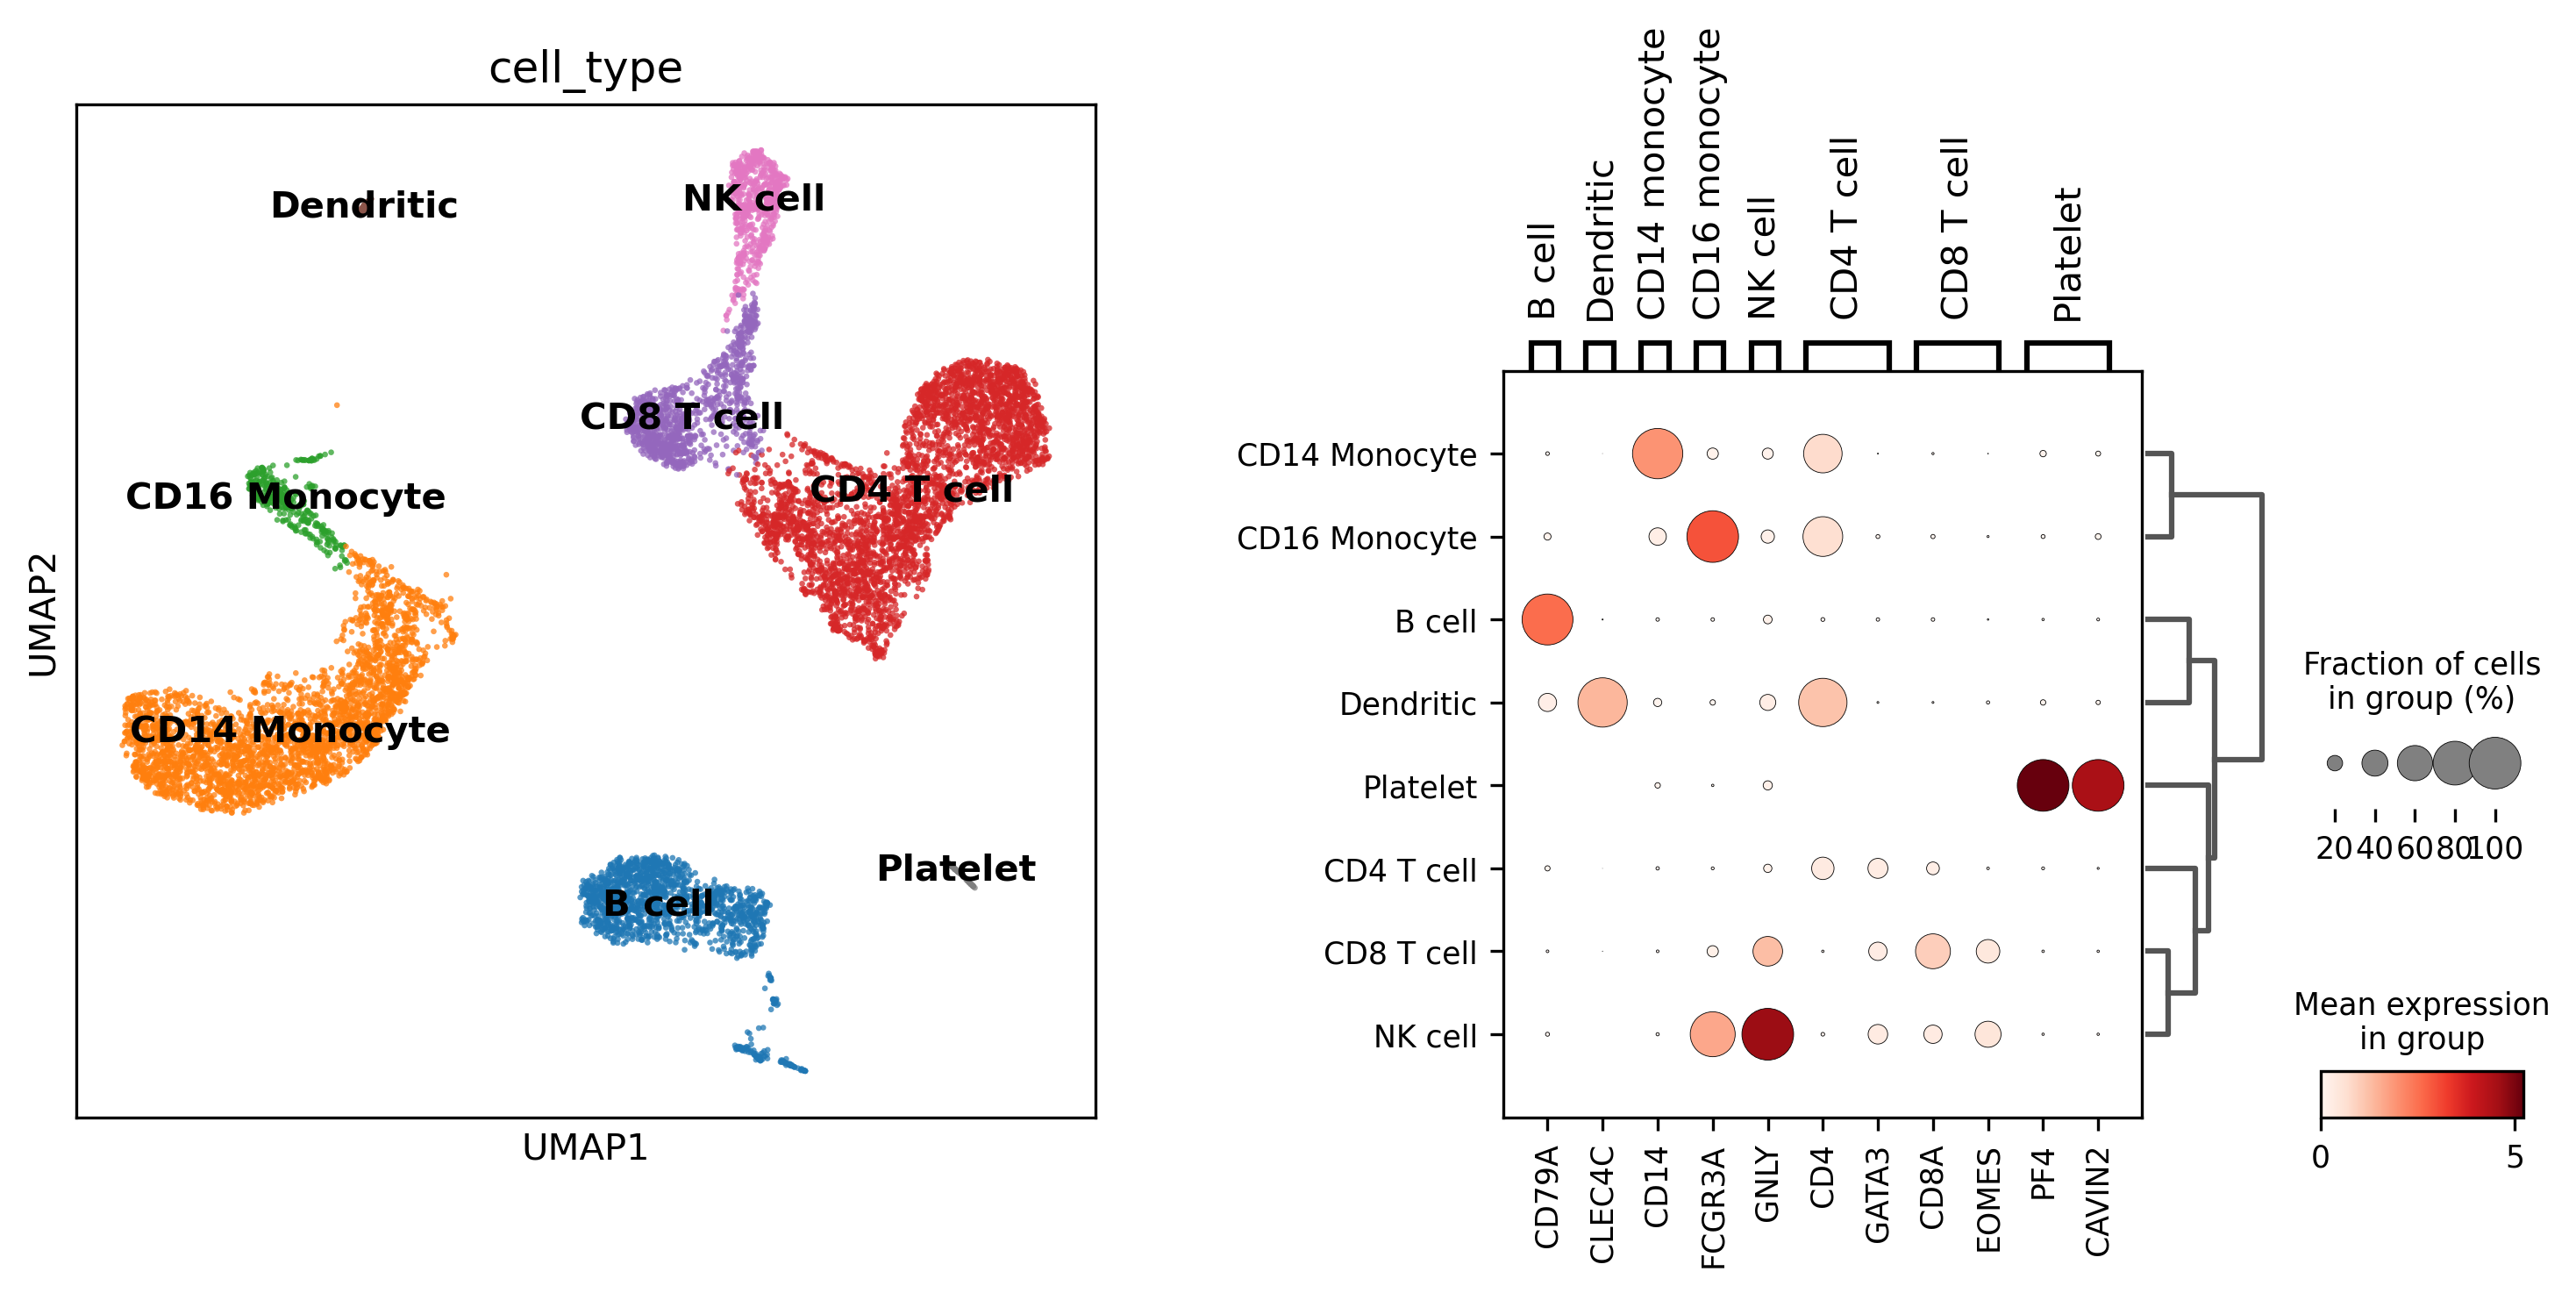

In [135]:
sc.tl.dendrogram(adNorm2, "cell_type")
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,5), gridspec_kw={'wspace':0.4})
ax1_dict = sc.pl.umap(adNorm2,color=['cell_type'], alpha=.75, s=10, legend_loc='on data', ax=ax1, show=False)
ax2_dict = sc.pl.dotplot(adNorm2, marker_genes_dict, 'cell_type', dendrogram=True,ax=ax2, show=False)
plt.show()

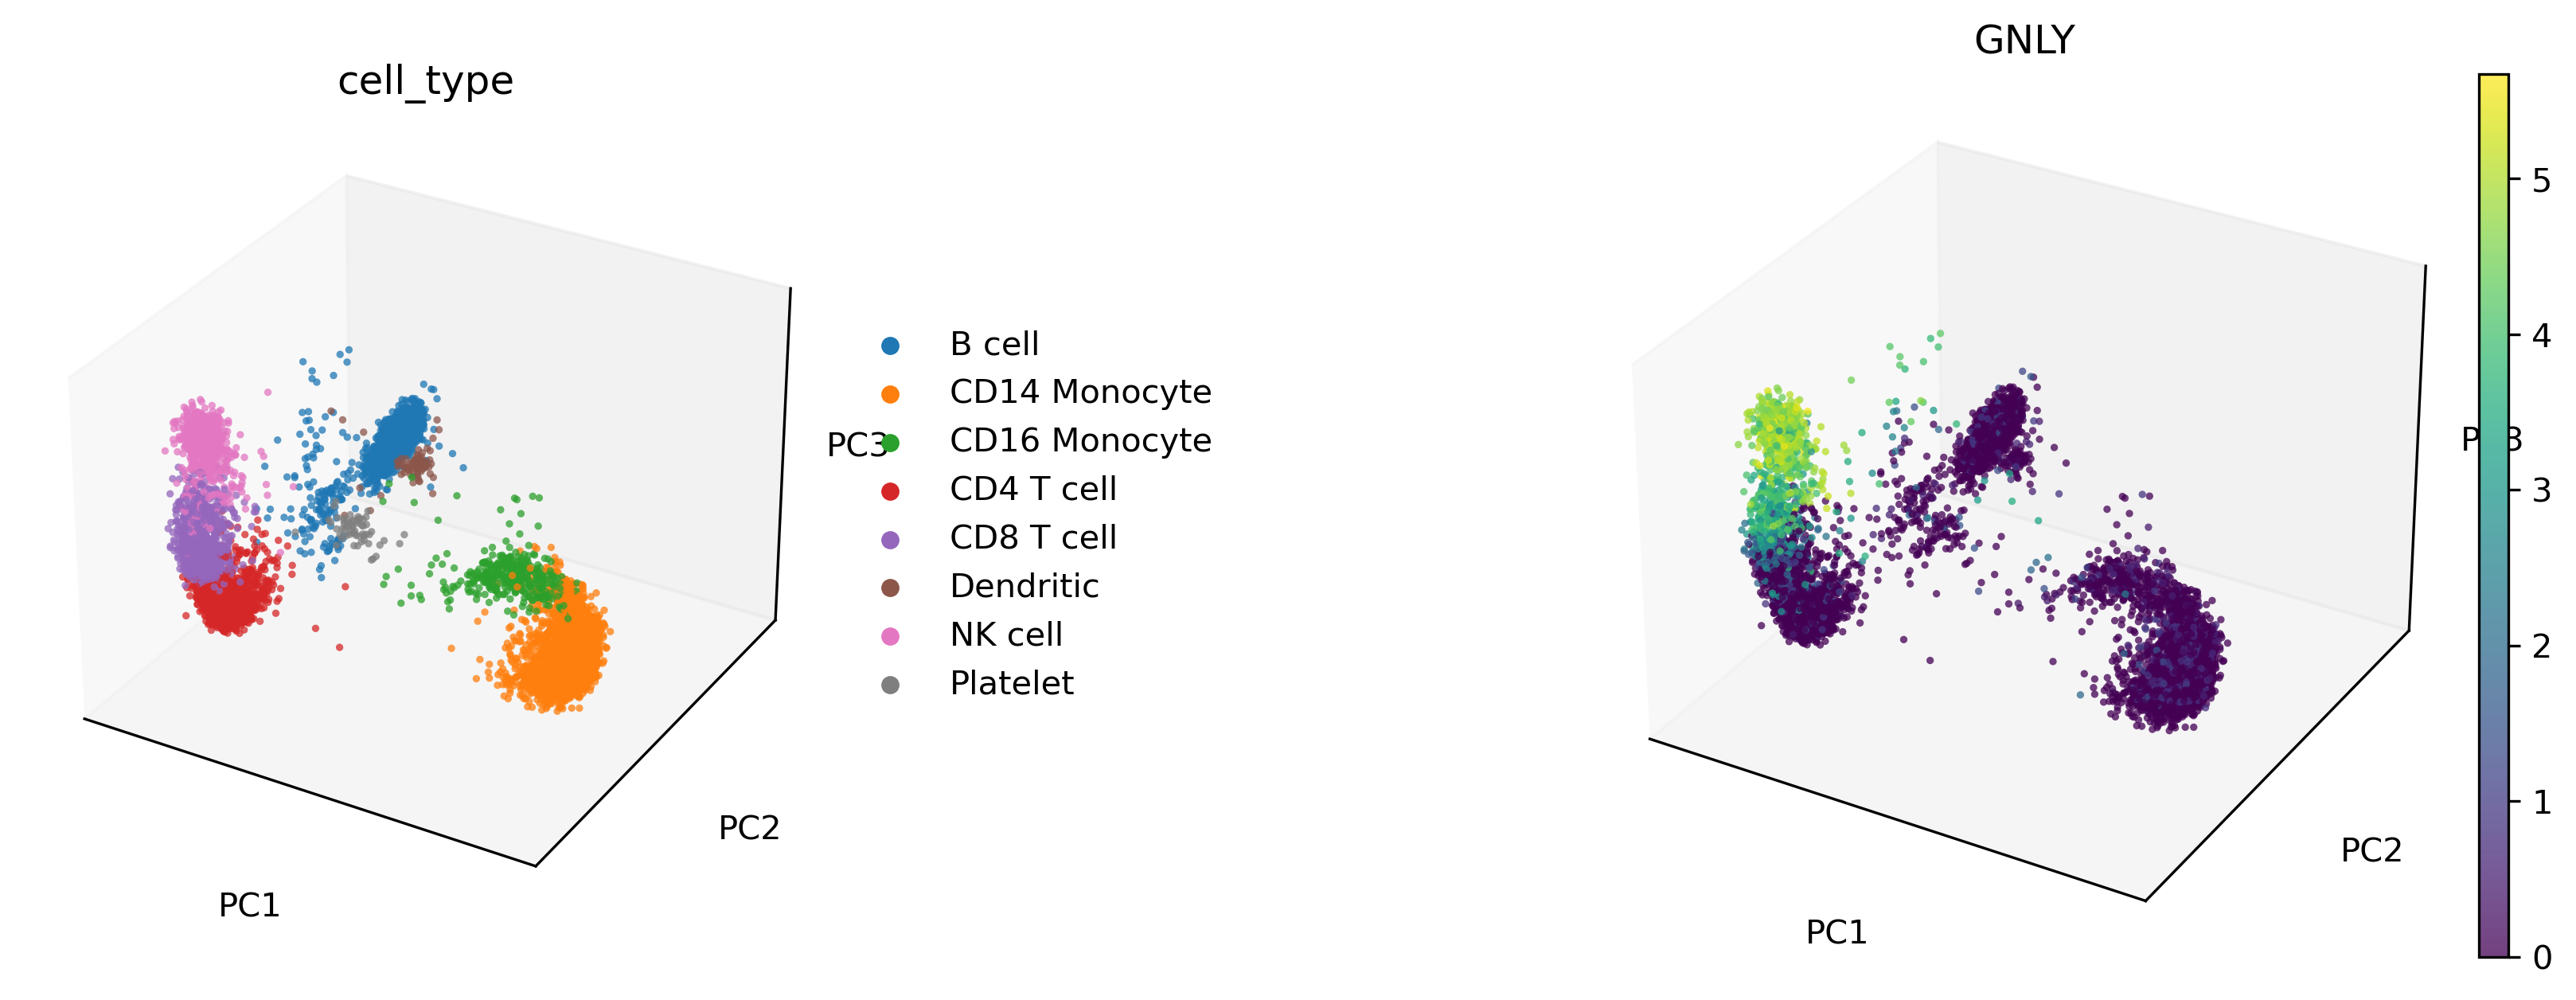

In [137]:
sc.pl.pca(adNorm2, color=['cell_type', 'GNLY'], alpha=.75, s=15, projection='3d')

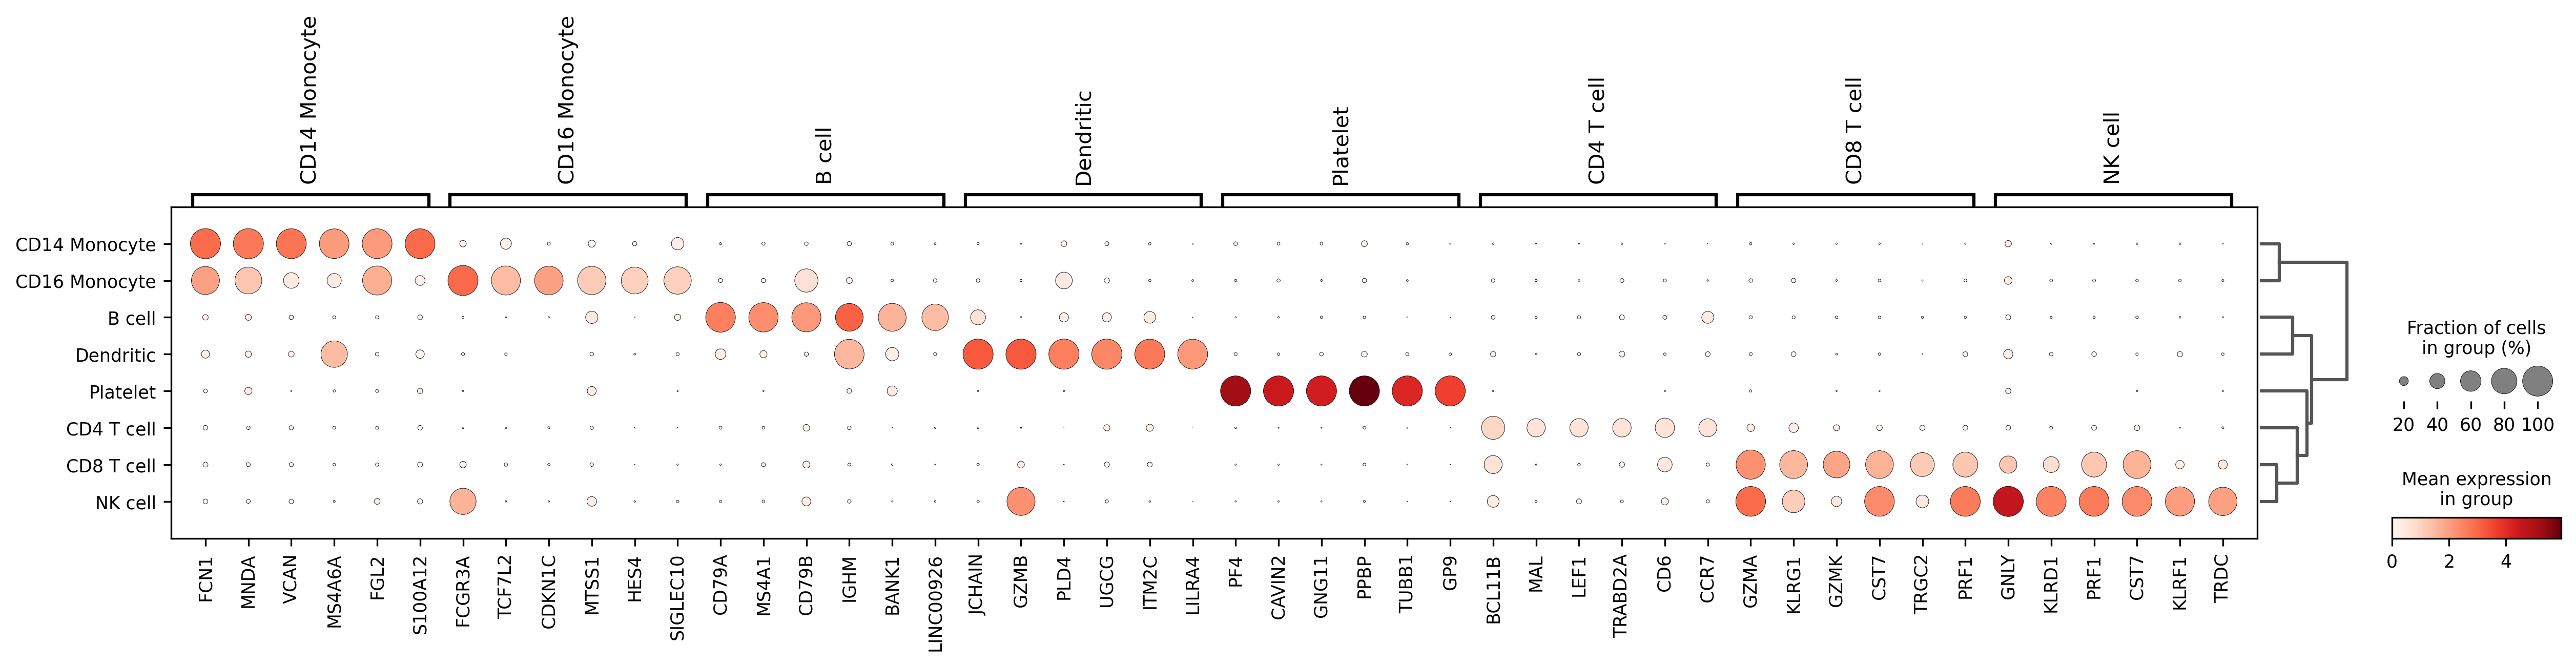

In [147]:
#remove any likely doublets by identifying genes preferntially expressed in each cluster vs all the others
sc.tl.rank_genes_groups(adNorm2, use_raw=False, groupby="cell_type")

#only display genes that meet criteria
sc.tl.filter_rank_genes_groups(adNorm2, min_fold_change=.7, min_in_group_fraction=.5, max_out_group_fraction=.15)

#dot plot of differentially expressed genes
sc.pl.rank_genes_groups_dotplot(adNorm2, n_genes=6, groupby="cell_type", dendrogram=True, key='rank_genes_groups_filtered')

## Question 2.


### How does this estimate of cell composition compare to prior literature?

**Deliverable 1: Function Definition**

First, we will definte the literature proportions given in the HW.

T cell: 70%
B cell: 15%
Natural killer (NK) cells: 10%
Monocyte: 5%
Dendritic cells: 1%

In [431]:
literature_prop = {
    "T Cell": 70,
    "B Cell": 15,
    "NK Cell": 10,
    "Monocyte": 5,
    "Dendritic": 1
}

We will use adNorm2's obs cell type column to calculate the estimate proportions.

We count up the number of cells per cell type. Then we can calculate proportion percentages for each cell type by dividing by the total sum of the counts.

In [433]:
counts = adNorm2.obs['cell_type'].value_counts()
estimate_prop = (counts / counts.sum()) *100
print(estimate_prop)

cell_type
CD4 T cell       34.151251
CD14 Monocyte    29.857184
B Cell           15.374293
CD8 T cell        9.882105
NK Cell           5.856417
CD16 Monocyte     3.527269
Dendritic         0.776383
Platelet          0.575098
Name: count, dtype: float64


We can write this proportion calculation for any annData object into the function used to plot and compare the cell compositions.

We define cell types to ensure that we use all the possible cell type categories from both literature and estimate proportions since they differ.

In [435]:
def cell_composition_comparison(literatureData, annData):
    counts = annData.obs['cell_type'].value_counts()
    estimate_prop = (counts / counts.sum()) *100

    #getting union from list and dictionary, convert into list with sorted for pandas later
    cell_types = sorted(set(estimate_prop.index).union(literatureData.keys()))

    #we turn these proportion into list values
    #over each cell type, we get the proportion and if it is missing we assign 0
    
    df = pd.DataFrame({
        "estimate_values": [estimate_prop.get(c, 0) for c in cell_types],
        "literature_values": [literatureData.get(c, 0) for c in cell_types]
    }, index = cell_types)

    bp = df.T.plot(kind = 'bar', stacked = True, figsize = (8, 6), width = 0.6)

    plt.show()

    #boxplot with dataframe
    

**Deliverable 2:** Output a stacked boxplot, comparing the proportions from our estimate scRNAseq and the literature.

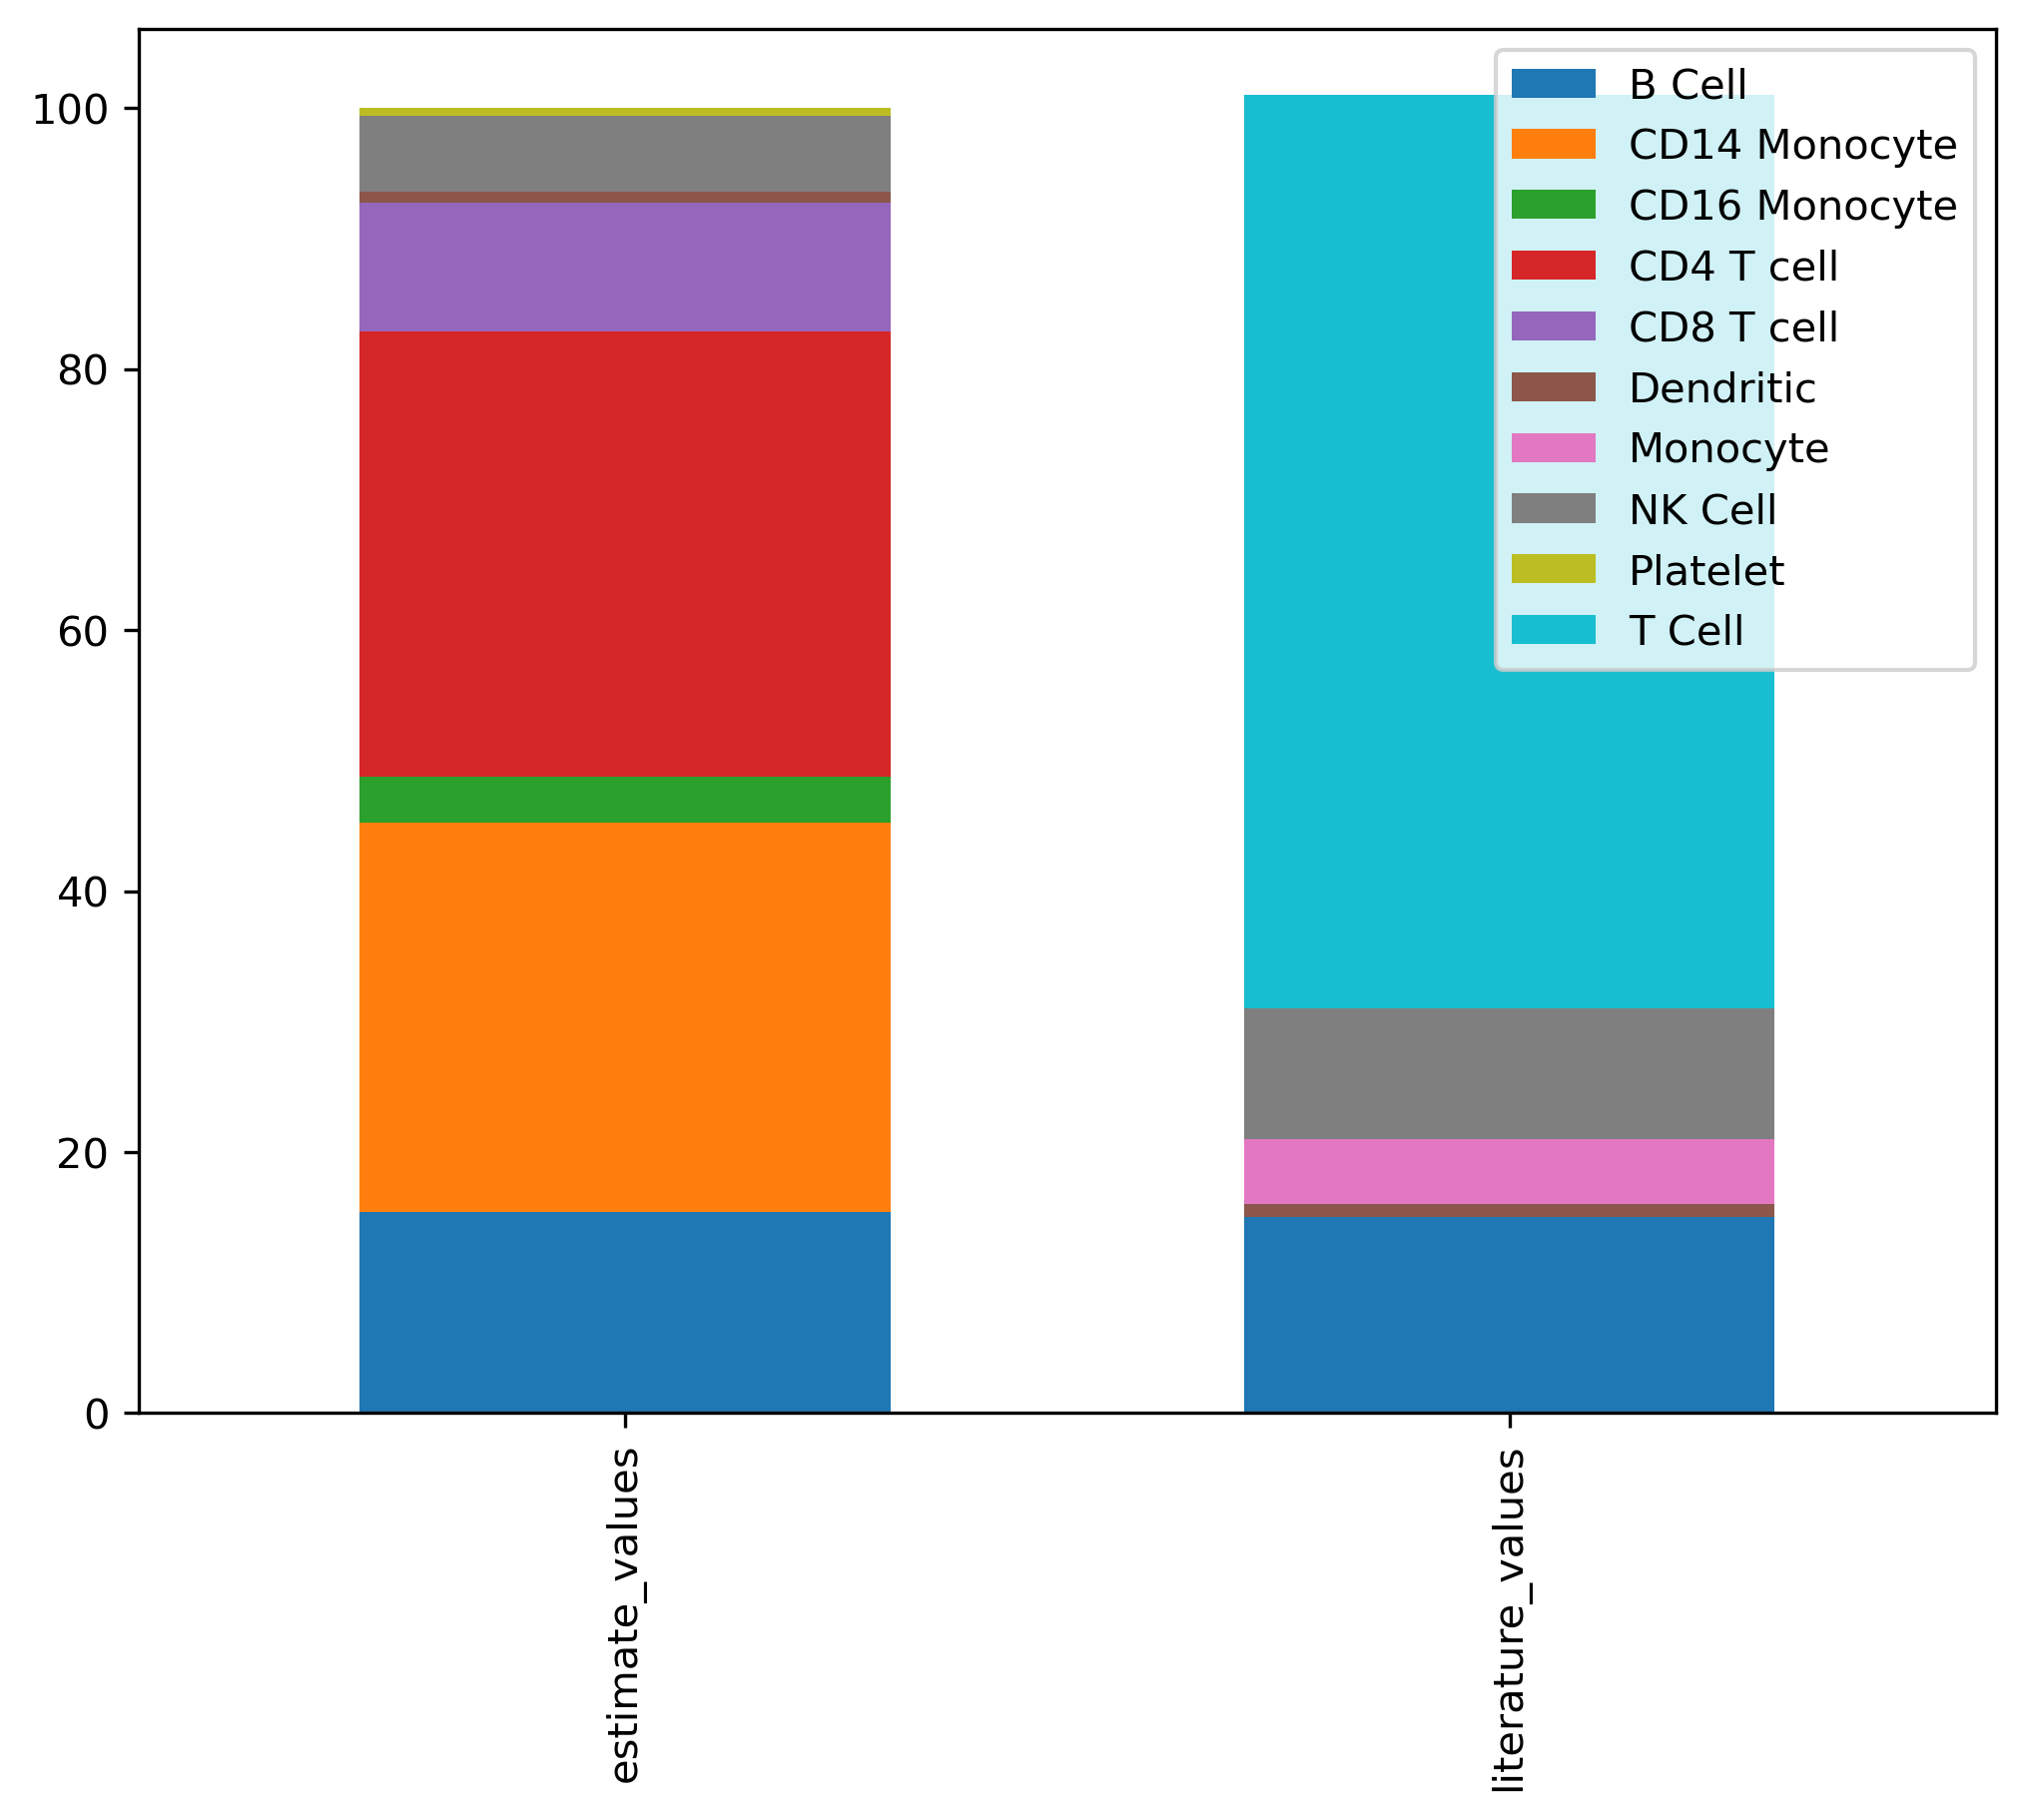

In [437]:
cell_composition_comparison(literature_prop, adNorm2)

## Question 3. 
### What are the transcriptional signatures of each of the PBMC cell types? 


**Deliverable 1: Preferentially expressed genes per cell type list.**

Use rank genes groups function to find differentially expressed genes for each cell type and use the Wilcoxon test to detect these genes.

In [441]:
sc.tl.rank_genes_groups(adNorm2, groupby = 'cell_type', use_raw = False, method = 'wilcoxon')

Then filter to remove weak or non-specific expressing genes.

min_fold_change = how much more highly expressed the gene is in the cell type vs. all other genes (0.7 means gene is 1.6x more in one cell type compared to others)

min_in_group_fraction = gene must be expressed in at least 50% of cells in a cell type to be significant

max_out_group_fraction = no more than x% of other cell types express the gene (gene should be specific to one cell type)

In [443]:
sc.tl.filter_rank_genes_groups(adNorm2, min_fold_change = 0.7, min_in_group_fraction = 0.5, max_out_group_fraction = 0.15)

Initialize an empty dictionary to store the top filtered genes for each cell type.

Loop through each cell type in the adNorm2 unstructured annotation data where the filter_rank_genes_groups creates and stores the data and get the gene name.

get.rank_genes_groups_df: retrieve the differentially expressed ranked genes for each group

Store the gene names in a list and use to create a dataframe to print for table format.

In [502]:
top_genes = {}

for ct in adNorm2.uns['rank_genes_groups_filtered'].get('names').dtype.names: 
    df = sc.get.rank_genes_groups_df (adNorm2, group = ct, key = 'rank_genes_groups_filtered')
    df = df.dropna(subset = ['names']) #remove NaN
    top_genes[ct] = df['names'].tolist()
    
top_genes_df = pd.DataFrame.from_dict(top_genes, orient = 'index').T.fillna('')

for cell_type, genes in top_genes.items():
    print(f"{cell_type}\n{genes}\n")
print(top_genes_df)
    

B Cell
['CD79A', 'MS4A1', 'CD79B', 'BANK1', 'IGHM', 'LINC00926', 'IGHD', 'CD22', 'RALGPS2', 'TNFRSF13C', 'BCL11A', 'VPREB3', 'SWAP70', 'TCL1A', 'BLK', 'FAM129C', 'P2RX5', 'SPIB', 'PLPP5', 'PDLIM1', 'FCER2', 'ARHGAP24', 'ADAM28', 'FCRL2', 'FCRL1', 'FCRL5', 'TCF4', 'SEL1L3', 'HLA-DOB', 'STRBP', 'AFF3', 'CD40', 'TPD52', 'EAF2']

CD14 Monocyte
['MNDA', 'VCAN', 'FCN1', 'S100A12', 'MS4A6A', 'AC020656.1', 'CD14', 'CSTA', 'FGL2', 'CD36', 'CSF3R', 'MPEG1', 'NCF2', 'KLF4', 'CPVL', 'CLEC7A', 'SERPINA1', 'CFD', 'PLBD1', 'TNFSF13B', 'TNFAIP2', 'KCTD12', 'CD68', 'DUSP6', 'BLVRB', 'CFP', 'TGFBI', 'TIMP2', 'FPR1', 'SLC7A7', 'LGALS2', 'ALDH2', 'SLC11A1', 'SPI1', 'CD302', 'RAB32', 'NUP214', 'CD93', 'CLEC12A', 'IGSF6', 'C5AR1', 'AC020916.1', 'MEGF9', 'LMO2', 'CPPED1', 'BST1', 'MGST1', 'RXRA', 'DMXL2', 'FCGR2A', 'OGFRL1', 'RAB31', 'PGD', 'LRP1', 'HCK', 'CDA', 'ASGR1', 'PLXDC2', 'CLEC4A', 'PRAM1', 'CCDC88A', 'RBP7', 'HNMT', 'IRAK3', 'AOAH', 'CD33', 'CD300E', 'LRRK2', 'PILRA', 'LILRB2', 'LRRC25', 'PLAUR', '

**Deliverable 2: Dotplot with expression and % cells.**

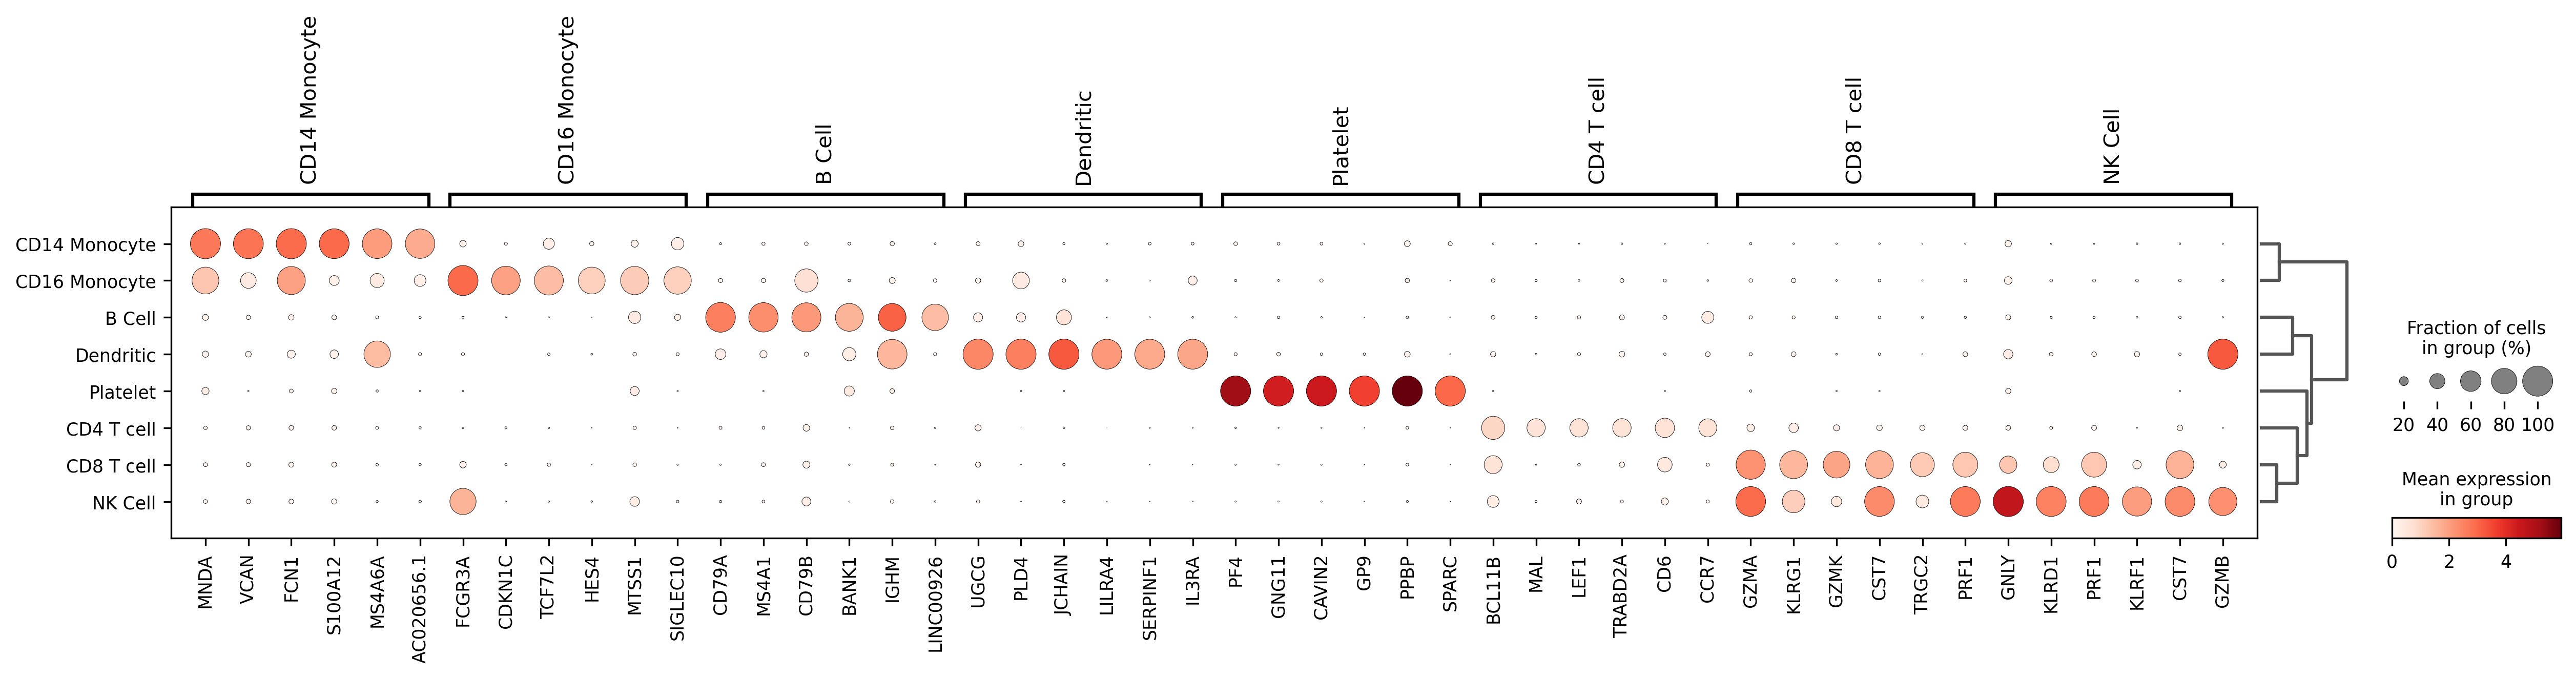

In [447]:
sc.pl.rank_genes_groups_dotplot(adNorm2, n_genes = 6, groupby = 'cell_type', dendrogram = True, key = 'rank_genes_groups_filtered')